# Predict Zestimate Logerror - EDA and Baseline Model

### *Introduction*  
Zillow's “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. A home is often the largest and most expensive purchase a person makes in his or her lifetime. Therefore, ensuring homeowners have a trusted way to monitor this asset is incredibly important. Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost. And by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

The goal of this project is to makes predictions about the future sale prices of homes. The prediction results are evaluated on **Mean Absolute Error** between the predicted log error and the actual log error. The logerror is defined as  $$logerror=log(Zestimate)−log(SalePrice)$$ and it is recorded in the transactions training data.  

### *About This Notebook*
This notebook focuses on 
1. **data exploration**, including visualization of correlation matrix and top features  
2. **data preparation** for machine learning algorithms, including imputing missing values, dealing with outliers, creating new features, and encoding categorical variables  
3. **baseline model**, i.e., buiding and comparing a naive model (predict the median), regularized linear model (Ridge), k-nearest neighbors, and tree-based ensemble model (RandomForestRegressor and GradientBoostingRegressor) by cross validation  

The data contains the list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016. Some key characteristics of this dataset are:
- The dataset contains both numerical and categorical features
- The correlation coefficients between the features and target variable are relatively small
- A large portion of the data are missing
- The target variables contains outliers

***Next Step:***
1. fine tune the models
2. model stacking

## 0 | Package and Configuration

In [53]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# initiate random seed
SEED = 8

In [4]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1 | Get Data

In [5]:
DATA_PATH = '../data'

def load_data(path, file_name):
    """load csv data and return dataframe"""
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

In [6]:
# load properties_2016.csv & train_2016_v2.csv
prop = load_data(DATA_PATH, file_name='properties_2016.csv')
train = load_data(DATA_PATH, file_name='train_2016_v2.csv')

In [7]:
# quick look at train
train.head(3)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [9]:
# quick look at prop
prop.head(3).transpose()

,0,1,2
parcelid,10754147,10759547,10843547
airconditioningtypeid,NaN,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,0,0,0
bedroomcnt,0,0,0
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,NaN,NaN,NaN
calculatedbathnbr,NaN,NaN,NaN
decktypeid,NaN,NaN,NaN


In [10]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

In [11]:
def downsize_data(df):
    """convert float64 to float32 and convert int64 to int32
    to reduce dataframe size and save memory
    """
    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        if dtype == np.int64:
            df[col] = df[col].astype(np.int32)
    return df

In [12]:
# convert float64/int64 to float32/int32 to save memory space
prop = downsize_data(prop)
train = downsize_data(train)

In [13]:
# merge prop and train
train_merge = pd.merge(train, prop, on='parcelid', how='left')
print('Dataframe size after merge: {}'.format(train_merge.shape))

Dataframe size after merge: (90275, 60)


In [14]:
# extract month and day from `transactiondate`
train_merge['month'] = train_merge['transactiondate'].apply(lambda x: int(x.split('-')[1]))
train_merge['day'] = train_merge['transactiondate'].apply(lambda x: int(x.split('-')[2]))

In [15]:
# drop `transactiondate` in train
train_merge.drop(['transactiondate', 'parcelid'], axis=1, inplace=True)
# drop `parcelid` in prop
prop.drop(['parcelid'], axis=1, inplace=True)

In [16]:
# set aside a test set
train_set, test_set = train_test_split(train_merge, test_size=0.2, random_state=SEED)
print('Training set size: {}\nTest set size: {}'.format(train_set.shape, test_set.shape))

Training set size: (72220, 60)
Test set size: (18055, 60)


## 2 | Data Exploration

In [17]:
# create a copy of train set for data exploration
data = train_set.copy()

### 2.1 Visualization of Features

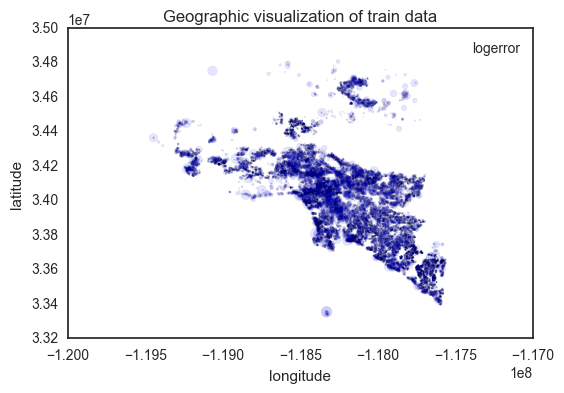

In [18]:
# visualize geo data
data.plot(kind='scatter', x='longitude', y='latitude', color='blue', alpha=0.1, 
          s=data['logerror']*20, label='logerror')
plt.title('Geographic visualization of train data')
plt.legend();

*Note: some geo-outliers are also logerror-outliers*

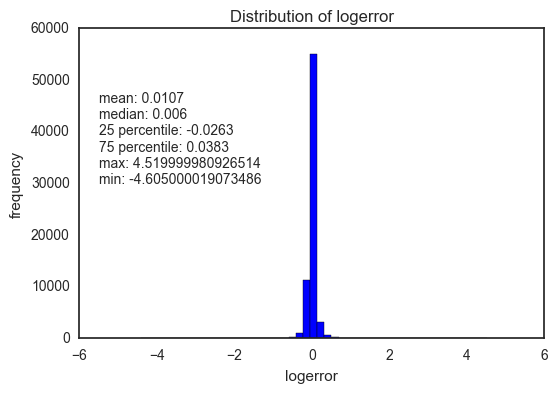

In [19]:
# target variable - `logerror`
# statistics
logerror_mn = round(data.logerror.mean(), 4)
logerror_median = round(data.logerror.median(), 4)
logerror_25 = round(np.percentile(data.logerror, 25), 4)
logerror_75 = round(np.percentile(data.logerror, 75), 4)
logerror_max = round(data.logerror.max(), 4)
logerror_min = round(data.logerror.min(), 4)

# distribution
data.logerror.hist(bins=50, facecolor='blue', grid=False)
plt.text(-5.5, 30000, 
         'mean: {}\nmedian: {}\n25 percentile: {}\n75 percentile: {}\nmax: {}\nmin: {}'.format(logerror_mn,
                                                                                               logerror_median,
                                                                                               logerror_25,
                                                                                               logerror_75,
                                                                                               logerror_max,
                                                                                               logerror_min))
plt.xlabel('logerror')
plt.ylabel('frequency')
plt.title('Distribution of logerror');

*Note: the mean/median logerror is close to 0 but the magnitude of the outliers is above 4* 

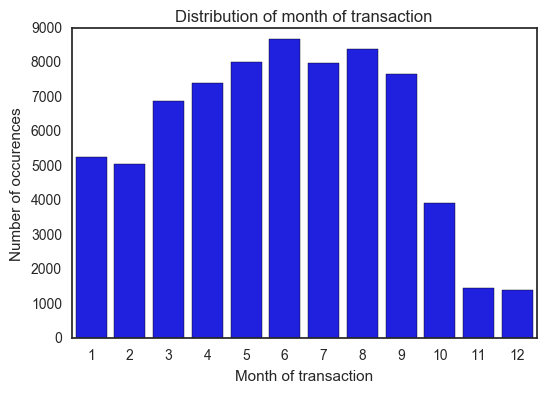

In [20]:
# visualize time data - month of transaction
cnt_month = data.month.value_counts()
sns.barplot(cnt_month.index, cnt_month.values, color='blue')
plt.xlabel('Month of transaction')
plt.ylabel('Number of occurences')
plt.title('Distribution of month of transaction');

*Note: the transaction records for Oct, Nov, and Dec only account for a small fraction, but the final prediction is for these 3 month*

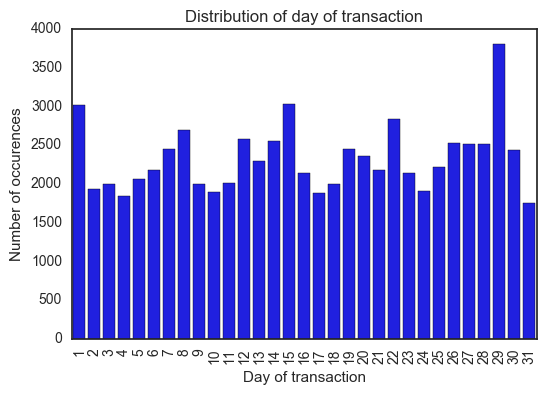

In [21]:
# visualize time data - day of transaction
cnt_day = data.day.value_counts()
sns.barplot(cnt_day.index, cnt_day.values, color='blue')
plt.xticks(rotation='vertical')
plt.xlabel('Day of transaction')
plt.ylabel('Number of occurences')
plt.title('Distribution of day of transaction');

*Note: there seems to be a weekly periodicity (there is a peak every 7 days)* 

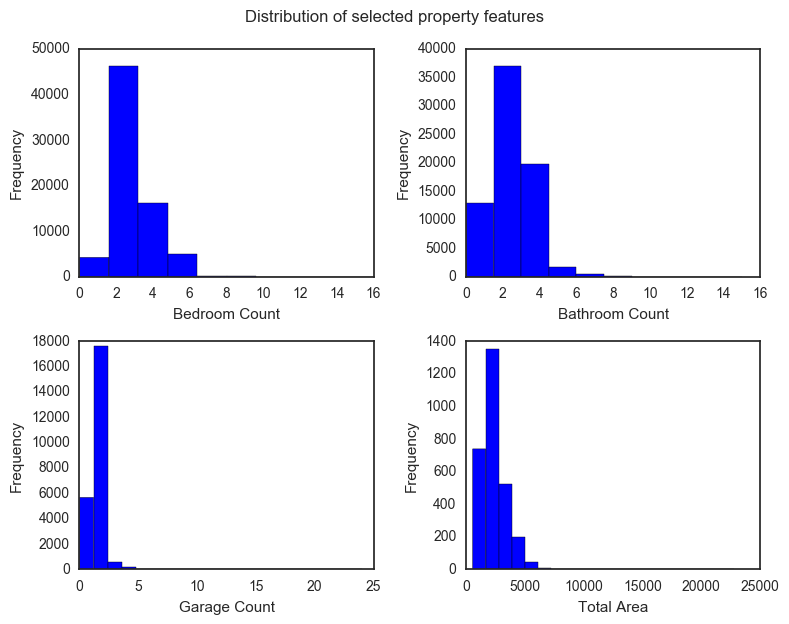

In [22]:
# some property-related features - `bedroomcnt`, `bathroomcnt`, `garagecarcnt`, `finishedsquarefeet15`
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
data.bedroomcnt.hist(bins=10, facecolor='blue', grid=False, ax=ax1)
ax1.set_xlabel('Bedroom Count')
ax1.set_ylabel('Frequency')

ax2 = fig.add_subplot(222)
data.bathroomcnt.hist(bins=10, facecolor='blue', grid=False, ax=ax2)
ax2.set_xlabel('Bathroom Count')
ax2.set_ylabel('Frequency')

ax3 = fig.add_subplot(223)
data.garagecarcnt.hist(bins=20, facecolor='blue', grid=False, ax=ax3)
ax3.set_xlabel('Garage Count')
ax3.set_ylabel('Frequency')

ax4 = fig.add_subplot(224)
data.finishedsquarefeet15.hist(bins=20, facecolor='blue', grid=False, ax=ax4)
ax4.set_xlabel('Total Area')
ax4.set_ylabel('Frequency')

plt.suptitle('Distribution of selected property features', y=1.03, fontsize=12)
fig.tight_layout();

### 2.2 Correlation of Features

In [23]:
# correlation
corr = data.corr()
corr.drop(['logerror'], axis=0, inplace=True)
corr_df = corr[['logerror']]
corr_df.sort_values('logerror', ascending=False, inplace=True)

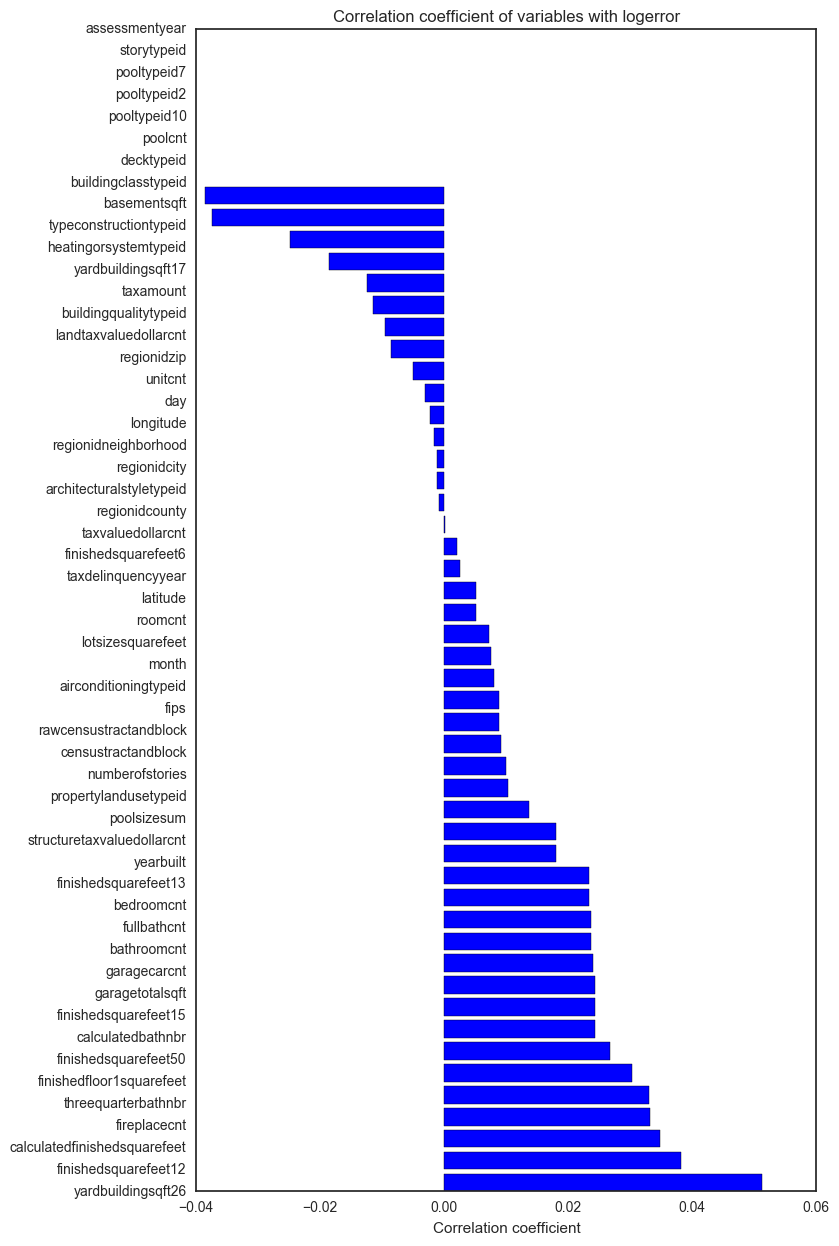

In [24]:
# plot correlation coefficient
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,15))
ax.barh(ind, np.array(corr_df.logerror.values), color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.index, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of variables with logerror");

*Note: overall correlation coefficients are low. 7 variables do not have a correlation coefficient with logerror because they only have 1 unique value*

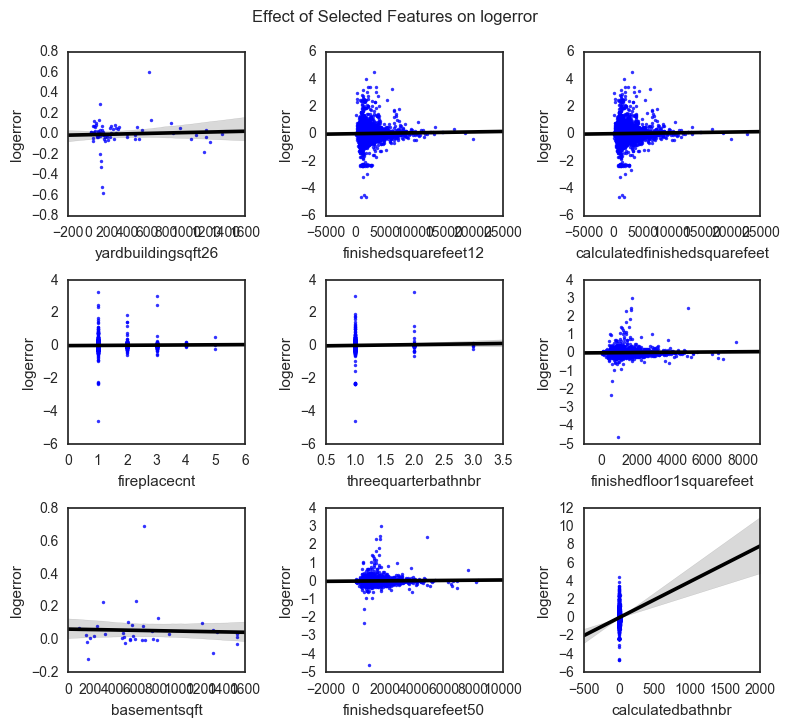

In [27]:
# plot top features
fig  = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(331) 
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333) 
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335) 
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337) 
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)

sns.regplot(x='yardbuildingsqft26', y='logerror', data=data, ax=ax1, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='finishedsquarefeet12', y='logerror', data=data, ax=ax2, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='calculatedfinishedsquarefeet', y='logerror', data=data, ax=ax3, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='fireplacecnt', y='logerror', data=data, ax=ax4, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='threequarterbathnbr', y='logerror', data=data, ax=ax5, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='finishedfloor1squarefeet', y='logerror', data=data, ax=ax6, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='basementsqft', y='logerror', data=data, ax=ax7, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='finishedsquarefeet50', y='logerror', data=data, ax=ax8, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})
sns.regplot(x='calculatedbathnbr', y='logerror', data=data, ax=ax9, \
            scatter_kws={'s': 6, 'color': 'blue'}, line_kws={'color': 'black'})

plt.suptitle('Effect of Selected Features on logerror', y=1.03, fontsize=12)
fig.tight_layout();

*Note: some of the top features actually have a large fraction of missing data*

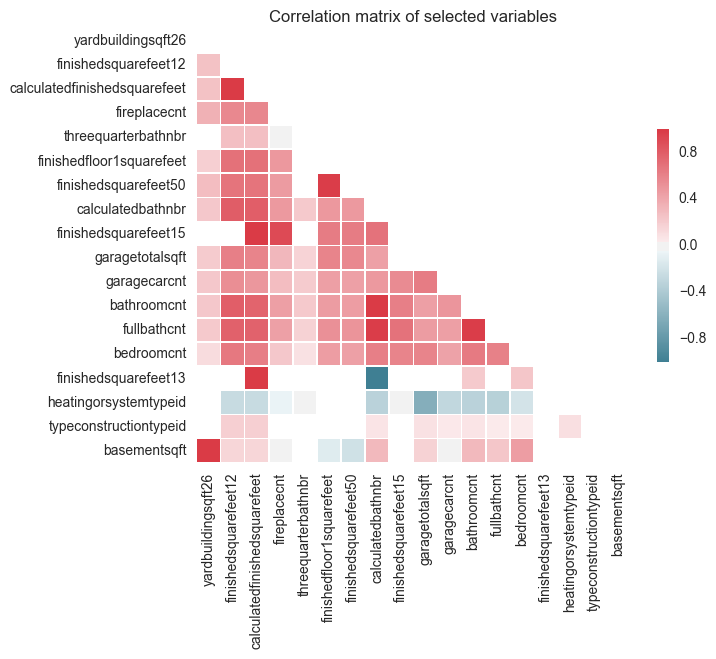

In [28]:
# correlations among the top features
cols = corr_df[(corr_df.logerror > 0.02) | (corr_df.logerror < -0.02)].index.tolist()
corr_selected = data[cols].corr()

# plot correlation matrix
f, ax = plt.subplots(figsize=(7, 6))
mask = np.zeros_like(corr_selected, dtype=np.bool) # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_selected, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of selected variables');

*Note: some of these selected variables - variables with relatively high correlation coefficient with logerror - are strongly correlated*

### 2.3 Experiment with New Features

In [29]:
# Average room size
data['N-AvgSize'] = data['calculatedfinishedsquarefeet']/(data['bedroomcnt'] + data['bathroomcnt'] + 1)

# Ratio of living area to lot area
data['N-PropLot'] = data['calculatedfinishedsquarefeet']/data['lotsizesquarefeet']

# Ratio of assessed property tax to total assessed tax
data['N-ValueRatio'] = data['taxamount']/data['taxvaluedollarcnt']

# Ratio of built structure value to land area value
data['N-StructLand'] = data['structuretaxvaluedollarcnt']/data['landtaxvaluedollarcnt']

In [30]:
# new correlation matrix after adding the 3 features
corr = data.corr()
corr['logerror'].sort_values(ascending=False)

logerror                        1.000000
yardbuildingsqft26              0.051206
finishedsquarefeet12            0.038200
calculatedfinishedsquarefeet    0.034733
fireplacecnt                    0.033191
threequarterbathnbr             0.032932
finishedfloor1squarefeet        0.030221
finishedsquarefeet50            0.026734
calculatedbathnbr               0.024359
finishedsquarefeet15            0.024334
garagetotalsqft                 0.024228
garagecarcnt                    0.023906
bathroomcnt                     0.023639
fullbathcnt                     0.023639
bedroomcnt                      0.023274
finishedsquarefeet13            0.023265
yearbuilt                       0.018037
structuretaxvaluedollarcnt      0.017960
poolsizesum                     0.013668
propertylandusetypeid           0.010213
N-StructLand                    0.010184
numberofstories                 0.009985
censustractandblock             0.009120
rawcensustractandblock          0.008874
fips            

*Note: new features do not show significant improvement compared to original features*

## 3 | Data Preparation

### 3.1 Missing Data

In [31]:
# missing data 
missing = data.isnull().sum().reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by='count')

In [32]:
# missing ratio
missing['ratio'] = missing['count']/data.shape[0]

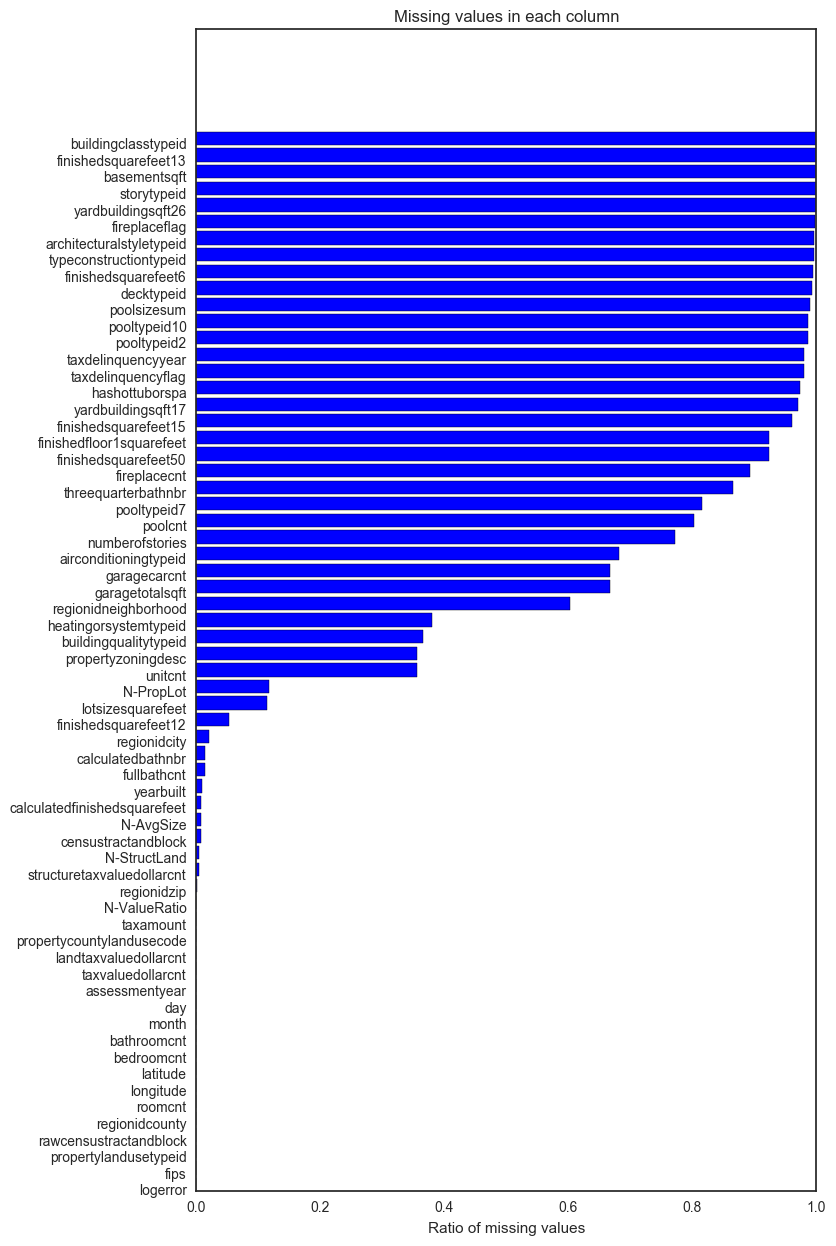

In [33]:
# plot missing data counts
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,15))
ax.barh(ind, missing['ratio'].values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing['column'].values, rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Missing values in each column");

*Note: some features have very high percentage of missing value - close to 100%*

Options for dealing with the missing values:

1. remove features (with too many missing values)
2. impute with median (for numerical features)

### 3.2 Outliers

In [34]:
# data with logerror outliers
outlier = data[(data['logerror'] > 0.49) | (data['logerror'] < -0.46)]
print(outlier.shape)

(1106, 64)


In [35]:
outlier.head().transpose()

,89389,293,54404,40153,72158
logerror,0.5014,1.083,0.6466,-0.5852,1.022
airconditioningtypeid,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,1,0,2,1,2
bedroomcnt,3,0,5,2,2
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,7,NaN,7,7,NaN
calculatedbathnbr,1,NaN,2,1,2
decktypeid,NaN,NaN,NaN,NaN,NaN


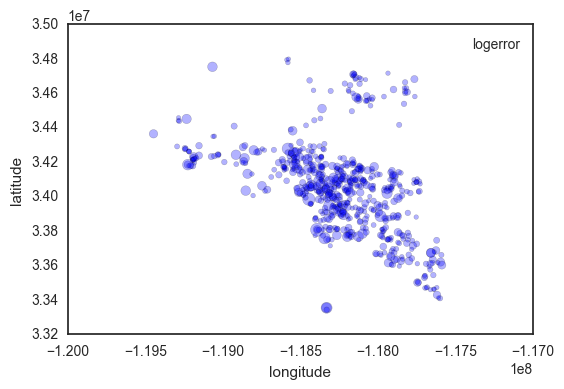

In [36]:
# visualize geo data for the outliers
outlier.plot(kind='scatter', x='longitude', y='latitude', color='blue', alpha=0.3, 
          s=outlier['logerror']*20, label='logerror')
plt.legend();

*Note: 1106 out of 72220 rows (less then 2% of data) have `logerror` potentially being outliers, should be safe to remove*

### 3.3 Transformer Class and Pipelines

In [37]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """select desired features and drop the rest"""
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.features]

In [38]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    """add new features including average size of rooms, ratio between living area and lot size,
    ratio between property tax and total tax, and ratio between structure value and land value"""
    def __init__(self, add_new_feature=True):
        self.add_new_feature = add_new_feature
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # define new features
        N_AvgSize = X['calculatedfinishedsquarefeet']/(X['bedroomcnt'] + X['bathroomcnt'] + 1)
        N_PropLot = X['calculatedfinishedsquarefeet']/X['lotsizesquarefeet']
        N_ValueRatio = X['taxamount']/X['taxvaluedollarcnt']
        N_StructLand = X['structuretaxvaluedollarcnt']/X['landtaxvaluedollarcnt']
        # add new features if True
        if self.add_new_feature:
            return np.c_[X, N_AvgSize, N_PropLot, N_ValueRatio, N_StructLand]
        else:
            return X

In [39]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    """drop features with percentage of missing missing values larger than missing_pct"""
    def __init__(self, missing_pct=1, drop_cols=[]):
        self.missing_pct = missing_pct # missing value percentage threshold
        self.drop_cols = drop_cols # initialize columns to drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if pd.isnull(X[col]).sum()/X.shape[0] >= self.missing_pct:
                self.drop_cols.append(col)
        X = X.drop(self.drop_cols, axis=1)
        return X

In [40]:
class CatTransformer(BaseEstimator, TransformerMixin):
    """categorival feature transformer: impute categorical value and encode categories"""
    def __init__(self, cat_dict):
        self.cat_dict = cat_dict
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if X[col].dtype == 'O':
                X[col].fillna('-99', inplace=True)
            X[col].fillna(-99, inplace=True)
            X[col] = X[col].astype('category', categories=self.cat_dict[col])
        return X

In [41]:
class DummyEncoder(TransformerMixin):
    """create dummy variables"""
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns)

In [42]:
# numerical features
num_features = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', \
             'threequarterbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',\
             'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', \
             'finishedsquarefeet15', 'finishedsquarefeet50', 'fireplacecnt', 'fullbathcnt', \
             'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', \
             'numberofstories', 'poolcnt', 'poolsizesum', 'roomcnt', \
             'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', \
             'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', \
             'taxamount', 'assessmentyear']

# categorical features
cat_features = ['airconditioningtypeid', 'decktypeid', 'architecturalstyletypeid', \
               'buildingclasstypeid', 'heatingorsystemtypeid', 'fips', 'fireplaceflag', \
               'hashottuborspa', 'pooltypeid10', 'pooltypeid2', 'propertylandusetypeid', \
               'propertyzoningdesc', 'regionidcounty', 'taxdelinquencyflag', 'propertycountylandusecode', \
                'rawcensustractandblock', 'censustractandblock', 'regionidcity', 'regionidzip', \
                'regionidneighborhood', 'storytypeid', 'pooltypeid7', 'typeconstructiontypeid', 'taxdelinquencyyear']

# potential features to drop (categorical variables with large number of levels) 
drop_features = ['propertycountylandusecode', 'rawcensustractandblock', 'censustractandblock', \
                 'regionidcity', 'regionidzip', 'regionidneighborhood', 'propertyzoningdesc']

In [43]:
# levels of categorical variables
categories = {}
for col in cat_features:
    if prop[col].dtype == 'O':
        prop[col].fillna('-99', inplace=True)
    prop[col].fillna(-99, inplace=True)
    categories[col] = prop[col].astype('category').cat.categories

In [45]:
# number of levels
{key: len(v) for key, v in categories.items()}

{'airconditioningtypeid': 8,
 'architecturalstyletypeid': 9,
 'buildingclasstypeid': 6,
 'censustractandblock': 458,
 'decktypeid': 2,
 'fips': 4,
 'fireplaceflag': 2,
 'hashottuborspa': 2,
 'heatingorsystemtypeid': 15,
 'pooltypeid10': 2,
 'pooltypeid2': 2,
 'pooltypeid7': 2,
 'propertycountylandusecode': 241,
 'propertylandusetypeid': 16,
 'propertyzoningdesc': 5639,
 'rawcensustractandblock': 472,
 'regionidcity': 187,
 'regionidcounty': 4,
 'regionidneighborhood': 529,
 'regionidzip': 406,
 'storytypeid': 2,
 'taxdelinquencyflag': 2,
 'taxdelinquencyyear': 33,
 'typeconstructiontypeid': 6}

In [46]:
# pipeline for numerical features
num_pipe = Pipeline([
        ('selector', DataFrameSelector(num_features)),
        ('feature_dropper', FeatureDropper(missing_pct=0.95)),
        ('feature_adder', FeatureAdder(add_new_feature=True)),
        ('imputer', Imputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

In [47]:
# pipeline for categorical features
cat_pipe = Pipeline([
        ('selector', DataFrameSelector(cat_features)), 
        ('feature_dropper', FeatureDropper(missing_pct=0.95, drop_cols=drop_features)),
        ('cat_transform', CatTransformer(categories)),
        ('get_dummy', DummyEncoder())
    ])

In [48]:
# full pipeline combining pipelines for numerical and categorical features
full_pipe = FeatureUnion([
        ('num_pipeline', num_pipe),
        ('cat_pipeline', cat_pipe)
    ])

## 4 | Model

In [49]:
train_wo_outlier = train_set[(train_set.logerror > -0.4) & (train_set.logerror < 0.42)]
train_w_outlier = train_set.copy()

In [50]:
labels = train_wo_outlier['logerror'].values
features = train_wo_outlier.drop(['logerror', 'day', 'month'], axis=1)

In [51]:
# transform features with full_pipe
features_transformed = full_pipe.fit_transform(features)

In [52]:
# naive predictor - median predictor
class NaivePredictor(BaseEstimator):
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.full((len(X), 1), 0.107)

In [58]:
# models to test
models = []
models.append(('Naive', NaivePredictor()))
models.append(('Ridge', Ridge()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('RF', RandomForestRegressor(random_state=SEED, max_depth=5)))
models.append(('GB', GradientBoostingRegressor(random_state=SEED)))

In [59]:
# evaluate each model
results = []
names = []
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

for name, model in models:
    cv_results = cross_val_score(model, features_transformed, labels, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print("%s: score mean %f (score std %f)" % (name, cv_results.mean(), cv_results.std()))

Naive: score mean -0.112401 (score std 0.000996)
Ridge: score mean -0.053185 (score std 0.001163)
KNN: score mean -0.060237 (score std 0.000961)
RF: score mean -0.053016 (score std 0.001060)
GB: score mean -0.052908 (score std 0.001109)


*Note: Ridge, RandomForestRegressor and GradientBoostingRegressor give similar scores*

=============================================== **THE END** ==================================================